# Multiclass semantic segmentation using DeepLabV3+

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/08/31<br>
**Last modified:** 2021/09/1<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

## Introduction

Semantic segmentation, with the goal to assign semantic labels to every pixel in an image,
is an essential computer vision task. In this example, we implement
the **DeepLabV3+** model for multi-class semantic segmentation, a fully-convolutional
architecture that performs well on semantic segmentation benchmarks.

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)

## Downloading the data

We will use the [Crowd Instance-level Human Parsing Dataset](https://arxiv.org/abs/1811.12596)
for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images.
Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification.
This dataset can be used for the "human part segmentation" task.

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
from google.colab import files
files.upload()


{}

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: images/
  inflating: images/r16219069037040.jpeg  
  inflating: images/r16219168976000.jpeg  
  inflating: images/r16219268910540.jpeg  
  inflating: images/r16219368858940.jpeg  
  inflating: images/r16219468840110.jpeg  
  inflating: images/r16219568818820.jpeg  
  inflating: images/r16219668825490.jpeg  
  inflating: images/r16219768829010.jpeg  
  inflating: images/r16219868842610.jpeg  
  inflating: images/r16219968901180.jpeg  
  inflating: images/r16220068924700.jpeg  
  inflating: images/r16220168928920.jpeg  
  inflating: images/r16220268891070.jpeg  
  inflating: images/r16220368836770.jpeg  
  inflating: images/r16220468777280.jpeg  
  inflating: images/r16271868052300.jpeg  
  inflating: images/r16271968044680.jpeg  
  inflating: images/r16272068063050.jpeg  
  inflating: images/r16272168055620.jpeg  
  inflating: images/r16272268048110.jpeg  
  inflating: images/r16272368039380.jpeg  
  inflating: images/r16272468030270.jpeg  
  inflating: i

In [8]:
mkdir data

In [9]:
!mv ./images ./data
!mv ./masks ./data

In [27]:
tf.__version__

'2.4.1'

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [2]:
def flip(image,mask):
    s = random.randint(0,10)
    model = lambda image:tf.image.flip_left_right(image)

    

    return model(image),model(mask)


# def zoom(image,mask):
#     s = random.randint(0,10)
#     model = tf.keras.Sequential([tf.keras.layers.RandomZoom(height_factor=(-0.4,-0.4),width_factor=(-0.4,-0.4),seed=s,fill_mode='nearest')])

#     return model(image),model(mask)

# def shift(image,mask):
#     s = random.randint(0,10)
#     model = tf.keras.Sequential([tf.keras.layers.RandomTranslation(height_factor=0.0,width_factor=0.4,seed=s,fill_mode='nearest')])

    return model(image),model(mask)

def augment(ds):
    # flip, zoom , translate horizontally
    flipped_ds  = ds.map(flip)
    # zoom_ds = ds.map(zoom)
    # shift_ds = ds.map(shift)

    # ds.concatenate(flipped_ds)
    # ds.concatenate(zoom_ds)
    # ds.concatenate(shift_ds)

    return flipped_ds



In [4]:
dataset = tf.data.Dataset.range(1, 6)
dataset2 = dataset.map(lambda x: x + 1)
list(dataset2.as_numpy_iterator())


[2, 3, 4, 5, 6]

In [3]:
import random
IMAGE_SIZE = 128
BATCH_SIZE = 4
NUM_CLASSES = 1
DATA_DIR = "./data"
NUM_TRAIN_IMAGES = 204
NUM_VAL_IMAGES = 20

train_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))
random.shuffle(train_images,lambda:0.5)
train_images = train_images[:NUM_TRAIN_IMAGES]


train_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))
random.shuffle(train_masks,lambda:0.5)
train_masks = train_masks[:NUM_TRAIN_IMAGES]



val_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))
random.shuffle(val_images,lambda:0.5)
val_images = val_images[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]


val_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))
random.shuffle(val_masks,lambda:0.5)
val_masks = val_masks[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, 1024],method='nearest')
        image = image/255
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, 1024])
        image = image /255
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # flip = augment(dataset)
    fd = dataset.map(flip)

    dataset.concatenate(fd)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

# train_data_aug  = augment(train_dataset)
# print("Augmented Dataset:",train_data_aug)

Train Dataset: <BatchDataset shapes: ((None, 128, 1024, 3), (None, 128, 1024, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((None, 128, 1024, 3), (None, 128, 1024, 1)), types: (tf.float32, tf.float32)>


## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [5]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [6]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, 1024, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    resnet50.trainable = True
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], 1024 // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], 1024 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation='sigmoid')(x)
    return keras.Model(inputs=model_input, outputs=model_output)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([100.0, 100000000000.0,10000000000.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1024, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 1030, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 512, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 512, 64)  256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

In [29]:
path = 'r16219069037040.png'
image = tf.io.read_file(path)
image = tf.image.decode_png(image, channels=1)
image.set_shape([None, None, 1])
image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE],method='nearest')
# image = image/255

# np.unique(image)
image.shape

TensorShape([512, 512, 1])

Epoch 1/1200
51/51 [==============================] - 22s 330ms/step - loss: 6.5425e-10 - accuracy: 0.9447 - val_loss: 0.0035 - val_accuracy: 0.9390
Epoch 2/1200
51/51 [==============================] - 16s 314ms/step - loss: 6.3847e-10 - accuracy: 0.9452 - val_loss: 0.0035 - val_accuracy: 0.9391
Epoch 3/1200
51/51 [==============================] - 16s 314ms/step - loss: 6.7718e-10 - accuracy: 0.9450 - val_loss: 0.0035 - val_accuracy: 0.9388
Epoch 4/1200
51/51 [==============================] - 16s 315ms/step - loss: 6.6719e-10 - accuracy: 0.9425 - val_loss: 0.0035 - val_accuracy: 0.9386
Epoch 5/1200
51/51 [==============================] - 16s 315ms/step - loss: 6.6427e-10 - accuracy: 0.9431 - val_loss: 0.0035 - val_accuracy: 0.9387
Epoch 6/1200
51/51 [==============================] - 16s 316ms/step - loss: 6.6352e-10 - accuracy: 0.9433 - val_loss: 0.0035 - val_accuracy: 0.9386
Epoch 7/1200
51/51 [==============================] - 16s 315ms/step - loss: 6.9448e-10 - accuracy: 0.9422

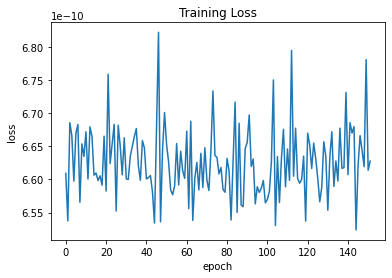

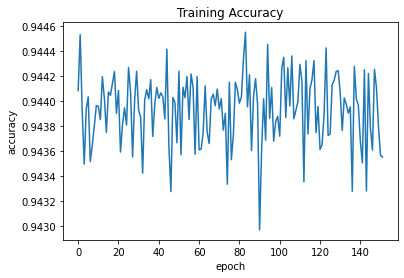

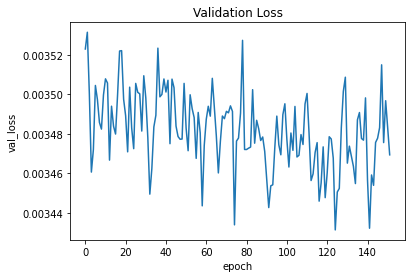

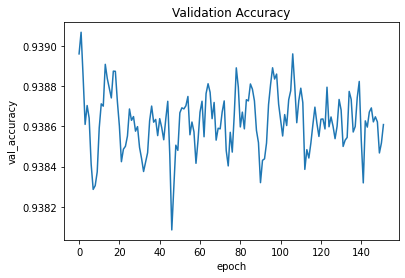

In [53]:
# model.reset_states()
ckpt_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoints/aug_model_free/95.h5',monitor='accuracy',save_weights_only=True)
# model.load_weights('./checkpoints/aug_model_free/acc935.h5')
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.00001,patience=150,verbose=1,restore_best_weights=True)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=loss,
    metrics=["accuracy"],
)
model
history = model.fit(train_dataset.map(add_sample_weights), validation_data=val_dataset.map(add_sample_weights), epochs=1200,callbacks=[ckpt_cb,es])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [7]:
model.load_weights('./checkpoints/aug_model_free/acc945.h5')

Epoch 1/10
51/51 [==============================] - 17s 336ms/step - loss: 2.1251e-09 - accuracy: 0.8075 - val_loss: 3.5831e-09 - val_accuracy: 0.7966
Epoch 2/10
51/51 [==============================] - 16s 320ms/step - loss: 2.1476e-09 - accuracy: 0.8080 - val_loss: 3.5774e-09 - val_accuracy: 0.7967
Epoch 3/10
51/51 [==============================] - 16s 321ms/step - loss: 2.1428e-09 - accuracy: 0.8079 - val_loss: 3.5920e-09 - val_accuracy: 0.7975
Epoch 4/10
51/51 [==============================] - 17s 322ms/step - loss: 2.1657e-09 - accuracy: 0.8085 - val_loss: 3.5821e-09 - val_accuracy: 0.7974
Epoch 5/10
51/51 [==============================] - 17s 322ms/step - loss: 2.1121e-09 - accuracy: 0.8085 - val_loss: 3.5893e-09 - val_accuracy: 0.7972
Epoch 6/10
51/51 [==============================] - 17s 323ms/step - loss: 2.2104e-09 - accuracy: 0.8085 - val_loss: 3.5964e-09 - val_accuracy: 0.7975
Epoch 7/10
51/51 [==============================] - 17s 323ms/step - loss: 2.2493e-09 - accura

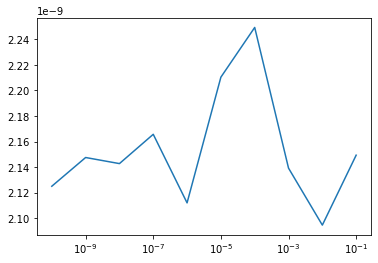

In [70]:
def cb(epoch):
    if epoch==0:
        return 1e-10
    return 1e-10*(10**epoch)
lrs = tf.keras.callbacks.LearningRateScheduler(cb)

history = model.fit(train_dataset.map(add_sample_weights), validation_data=val_dataset.map(add_sample_weights), epochs=10,callbacks=[lrs])

plt.semilogx(history.history['lr'],history.history['loss'])


In [64]:
history = model.fit(train_dataset.map(add_sample_weights), validation_data=val_dataset.map(add_sample_weights), epochs=500,callbacks=[ckpt_cb])

Epoch 1/100
51/51 [==============================] - 17s 329ms/step - loss: 3.0332e-09 - accuracy: 0.7398 - val_loss: 5.6332e-09 - val_accuracy: 0.7044
Epoch 2/100
51/51 [==============================] - 17s 327ms/step - loss: 3.0310e-09 - accuracy: 0.7399 - val_loss: 5.6363e-09 - val_accuracy: 0.7047
Epoch 3/100
51/51 [==============================] - 17s 332ms/step - loss: 3.0288e-09 - accuracy: 0.7401 - val_loss: 5.6388e-09 - val_accuracy: 0.7050
Epoch 4/100
51/51 [==============================] - 17s 328ms/step - loss: 3.0266e-09 - accuracy: 0.7402 - val_loss: 5.6427e-09 - val_accuracy: 0.7053
Epoch 5/100
51/51 [==============================] - 17s 328ms/step - loss: 3.0245e-09 - accuracy: 0.7404 - val_loss: 5.6465e-09 - val_accuracy: 0.7056
Epoch 6/100
51/51 [==============================] - 17s 327ms/step - loss: 3.0223e-09 - accuracy: 0.7405 - val_loss: 5.6504e-09 - val_accuracy: 0.7059
Epoch 7/100
51/51 [==============================] - 17s 327ms/step - loss: 3.0202e-09 -

In [60]:
# model.load_weights('weights_l2_binary.h5')
model.save_weights('./checkpoints/weights128x1024r13.h5')

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [9]:
colormap  = np.array([[1.0,0,0],[0,0,1.0]])


In [17]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    # predictions = np.argmax(predictions,axis=1)
    predictions = np.round(predictions)
    predictions = np.expand_dims(predictions,axis=-1)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    # for l in range(0, n_classes):
    #     l+=1
    #     idx = mask == l
    #     r[idx] = colormap[l, 0]
    #     # g[idx] = colormap[l, 1]
    #     # b[idx] = colormap[l, 2]
    r = mask.astype(np.uint8)
    rgb = np.stack([r, g, b],axis=-1)
    rgb = np.reshape(rgb,(128,1024,3))
    # print('Source mask shape:{}'.format(rgb.shape))
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    np.reshape(colored_mask,(128,1024,3))
    # print('Mask:{}'.format(colored_mask.shape))
    # print('Image:{}'.format(image.shape))
    overlay = cv2.addWeighted(image, 0.1, colored_mask, 8.0, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()



def plot_predictions(images_list, colormap, model):
    n_classes=1
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, n_classes)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )



In [ ]:
np.unique(predictions)

array([0., 1.], dtype=float32)

In [ ]:
# # # Loading the Colormap
# # colormap = loadmat(
# #     "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
# # )["colormap"]
# # colormap = colormap * 100
# colormap = colormap.astype(np.uint8)


# def infer(model, image_tensor):
#     predictions = model.predict(np.expand_dims((image_tensor), axis=0))
#     predictions = np.squeeze(predictions)
#     predictions = np.argmax(predictions, axis=2)
#     return predictions


# def decode_segmentation_masks(mask, colormap, n_classes):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)
#     for l in range(0, n_classes):
#         idx = mask == l
#         r[idx] = colormap[l, 0]
#         # g[idx] = colormap[l, 1]
#         # b[idx] = colormap[l, 2]
#     rgb = np.stack([r, g, b], axis=-1)
#     return rgb


# def get_overlay(image, colored_mask):
#     image = tf.keras.preprocessing.image.array_to_img(image)
#     image = np.array(image).astype(np.uint8)
#     overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
#     return overlay


# def plot_samples_matplotlib(display_list, figsize=(5, 3)):
#     _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
#     for i in range(len(display_list)):
#         if display_list[i].shape[-1] == 3:
#             axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         else:
#             axes[i].imshow(display_list[i])
#     plt.show()


# def plot_predictions(images_list, colormap, model):
#     n_classes=1
#     for image_file in images_list:
#         image_tensor = read_image(image_file)
#         prediction_mask = infer(image_tensor=image_tensor, model=model)
#         prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, n_classes)
#         overlay = get_overlay(image_tensor, prediction_colormap)
#         plot_samples_matplotlib(
#             [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
#         )


### Inference on Train Images

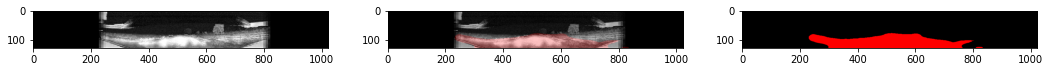

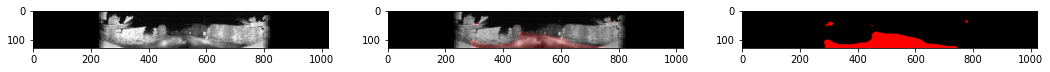

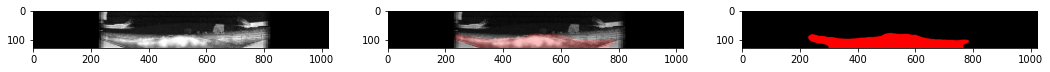

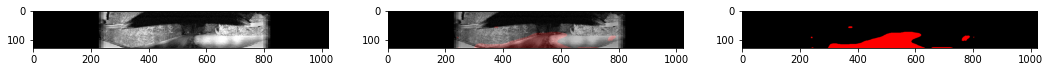

In [18]:
plot_predictions(train_images[4:8], colormap, model=model)

### Inference on Validation Images

In [14]:
plot_predictions(val_images[:20], colormap, model=model)

NameError: name 'plot_samples_matplotlib' is not defined